# import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from tqdm import tqdm
from PIL import Image
import pickle
import models.optimizer.optimizer as optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

# todo: select model here, uncomment to select the model
from models import Alex_4096_relu as m
# from models import VGG16_4096 as m

from helper.training_early_stop import EarlyStop
import helper.utility as utility
import os

# select device

In [2]:
# select device
device = utility.select_devices(use_cudnn_if_avaliable=True)

using CUDA + cudnn


# Data Pre-processing

### transformer parameter

In [3]:
size = (227, 227)
batch_size = 64
channels = 3

### transformer

In [4]:
data_transforms_R = utility.grayscale_transform_rotation(channels, size, 45,)
data_transforms_vf = utility.grayscale_transform_verticalflip(channels, size, 1.0)
data_transforms_hf = utility.grayscale_transform_horizontalflip(channels, size, 1.0)
data_transforms_crop = utility.grayscale_transform_crop(channels, size, scale=(0.3, 1))
data_transforms_translate = utility.grayscale_transform_trainslate(channels, size, value=(0.2, 0.2))
data_transforms_shear = utility.grayscale_transform_shear(channels, size, value=(-20, 20))

data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=channels), 
    transforms.Resize(size),
    transforms.ToTensor()
])

### data duplicated (use if needed)

In [5]:
utility.create_augmentation_dataset('../dataset/train/', 'dataset1_disgust', 'disgust')

data augmentation is already created at [../augmentation_dataset/dataset1_disgust/]


### create dataloader

#### dataloader 1

In [6]:
train_path = '../dataset/splited_data/train_data/'
val_path = '../dataset/splited_data/validation_data/'
test_path = '../dataset/test'
rotation = datasets.ImageFolder(train_path, transform=data_transforms_R)
vertical_flip = datasets.ImageFolder(train_path, transform=data_transforms_vf)
horizontal_flip = datasets.ImageFolder(train_path, transform=data_transforms_hf)
crop = datasets.ImageFolder(train_path, transform=data_transforms_crop)
shear = datasets.ImageFolder(train_path, transform=data_transforms_shear)
translate = datasets.ImageFolder(train_path, transform=data_transforms_translate)

train_dataset1 = datasets.ImageFolder(train_path, transform=data_transforms)
train_dataset1 = ConcatDataset([train_dataset1, vertical_flip, vertical_flip, horizontal_flip, crop, shear, translate])
val_dataset1 = datasets.ImageFolder(val_path, transform=data_transforms)
test_dataset1 = datasets.ImageFolder(test_path, transform=data_transforms)

train_loader = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=16)
val_loader = DataLoader(val_dataset1, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)
test_loader = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=16)

#### dataloader 2

In [7]:
train_path = '../dataset2_MMAFEDB/train'
val_path = '../dataset2_MMAFEDB/valid'
test_path = '../dataset2_MMAFEDB/test'

rotation = datasets.ImageFolder(train_path, transform=data_transforms_R)
vertical_flip = datasets.ImageFolder(train_path, transform=data_transforms_vf)
horizontal_flip = datasets.ImageFolder(train_path, transform=data_transforms_hf)
crop = datasets.ImageFolder(train_path, transform=data_transforms_crop)
shear = datasets.ImageFolder(train_path, transform=data_transforms_shear)
translate = datasets.ImageFolder(train_path, transform=data_transforms_translate)

train_dataset2 = datasets.ImageFolder(train_path, transform=data_transforms)
# train_dataset2 = ConcatDataset([train_dataset2, vertical_flip, vertical_flip, horizontal_flip, crop, shear, translate])
val_dataset2 = datasets.ImageFolder(val_path, transform=data_transforms)
test_dataset2 = datasets.ImageFolder(test_path, transform=data_transforms)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=16)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=16)

#### select data loader

In [8]:
tl = train_loader2
vl = val_loader2

### check data detial

In [9]:
# check if the size of each label is balanced
print('Train label:')
train_label_count = utility.check_label_size(tl)
print('val label:')
val_label_count = utility.check_label_size(vl)

Train label:
Label 4: 29384 samples
Label 6: 8113 samples
Label 2: 4859 samples
Label 3: 28592 samples
Label 5: 12223 samples
Label 0: 6566 samples
Label 1: 3231 samples
val label:
Label 0: 1017 samples
Label 1: 656 samples
Label 2: 659 samples
Label 3: 5475 samples
Label 4: 5839 samples
Label 5: 2236 samples
Label 6: 1474 samples


# Model parameter

In [10]:
pth_path = './model_data/Alex_4096_relu_Adam_d1_wb_A/model.pth'
model = m.EmotionCNN(num_classes=7, input_channel=3)
model.load_state_dict(torch.load(pth_path))

# todo: select optimizer
optimizer_name = "Adam"  # or "SGD"
# optimizer_name = "SGD"

# saving path
m.update_file_name(optimizer_name + "_d1d2_wb_tl")

# initialize model
if not os.path.exists(m.record_save_path):
    os.makedirs(m.record_save_path)

In [11]:
# adjust the weight of each label
class_weights = utility.balance_weight(train_label_count, len(tl), batch_size)

# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()))).to(device)

adjusted weights: OrderedDict([(4, 0.45210221306055776), (6, 1.6374425525171241), (2, 2.734013465439685), (3, 0.4646254696618435), (5, 1.0868503173174695), (0, 2.0232365867455724), (1, 4.111597470928947)])


In [12]:
# loss-function and optimizer
optimizer_ = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
# optimizer_ = optimizer.create_optimizer(model.parameters(), optimizer_name)

lr_scheduler = ReduceLROnPlateau(
            optimizer_,
            mode='max',                 # 'max' for monitoring validation accuracy
            factor=0.4,                 # factor by which the learning rate will be reduced
            patience=5,                 # number of epochs with no improvement to trigger LR reduction
            min_lr=1e-7,                # minimum learning rate
            verbose=1                   # (1: print messages, 0: not print message)
        )

### transfer learning (add FC)

In [13]:
# for param in model.parameters():
#     param.requires_grad = False

new_fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 7))
model.classifier = new_fc

#### earlystoping parameters

In [14]:
# average loss / epoch
loss_history_per_epoch = []
# correct prediction / epoch
correct_prediction_pre_epoch = []
# accuracy / epoch
accuracy_per_epoch = []
# validation loss
val_loss_per_epoch = []
# validation accuracy
val_accuracy_per_epoch = []

In [15]:
# training model
num_epochs = 2000

# early stopping variables
stop_counter = 25 # number of count to trigger early stop
stop_counter_window = 15 # a range to check stop_counter
loss_different = 0.001 # different between the best val loss and the most recent one
accuracy_different = 0.001
stop_counter_interval = 30 # check for early stop for every stop_counter_interval
counter = 0 # number of count for every trail of early stop
is_always = True # always check for early stop, set to true will ignore other setting except stop_counter
is_exe = False # is early stop running
run_after =0
early_stopping = EarlyStop(m.pth_save_path, m.pth_save_path_loss, stop_counter, 
                           accuracy_different, loss_different, type="accuracy")

# 2. Model training

In [16]:
model.to(device)
# progress bar
process = tqdm(range(num_epochs), bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}', colour='green', unit='epoch')

for epoch in process:
    running_loss = 0.0
    accuracy = 0.0
    model.train()
    for inputs, labels in tl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer_.zero_grad()
        loss.backward()
        optimizer_.step()
        running_loss += loss.item()
        probability = nn.functional.softmax(outputs, dim=1)
        _, prediction = torch.max(probability, dim=1)
        num_correct_prediction = (prediction == labels).sum().item()
        correct_prediction_pre_epoch.append(num_correct_prediction)
        accuracy += num_correct_prediction / inputs.shape[0]
    # save training status
    loss_history_per_epoch.append((running_loss / len(tl)))
    accuracy_per_epoch.append((accuracy / len(tl)))

    # training validation + early stopping
    if epoch >= run_after and (is_always or is_exe or epoch % stop_counter_interval == 0):
        val_loss = 0.0
        val_accuracy = 0.0

        if not is_always and epoch% stop_counter_interval ==0:
            early_stopping.counter = 0
            is_exe = True

        counter += 1

        if not is_always and counter >= stop_counter_window:
            counter = 0
            is_exe = False
        model.eval()
        with torch.no_grad():
            for inputs, labels in vl:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                probability = nn.functional.softmax(outputs, dim=1)
                _, prediction = torch.max(probability, dim=1)
                num_correct_prediction = (prediction == labels).sum().item()
                accuracy = num_correct_prediction / inputs.shape[0]
                val_accuracy += accuracy
        val_loss = val_loss / len(vl)
        val_accuracy = val_accuracy / len(vl)
        val_loss_per_epoch.append(val_loss)
        val_accuracy_per_epoch.append(val_accuracy)

        early_stopping.check_status(model, val_accuracy, val_loss)

        # display recently 5 average loss of epochs
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"val loss= {'{:.5f}'.format(val_loss_per_epoch[-1])} - "
                                f"best_loss= {'{:.5f}'.format(early_stopping.best_of_all_value_loss)} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])} - "
                                f"val accuracy= {'{:.3%}'.format(val_accuracy_per_epoch[-1])} - "
                                f"best= {'{:.3%}'.format(early_stopping.best_of_all_value)} - "
                                f"Counter= {early_stopping.counter}/{stop_counter}")
    else:
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])}")

    if early_stopping.early_stop:
        print('\nTrigger Early Stopping\n')
        early_stopping.early_stop = False
        break

loss= 1.36033 - val loss= 1.61913 - best_loss= 1.61183 - accuracy= 56.849% - val accuracy= 45.263% - best= 46.009% - Counter= 0/25:   6%|█▎                  | 130/2000 [1:00:50<14:35:15, 28.08s/epoch] 


Trigger Early Stopping



# 3. Save model and records

In [17]:
# save the pth file
torch.save(model.state_dict(), m.pth_manual_save_path)

utility.save_pickle_files(loss_history_per_epoch, m.record_save_path + '/loss_history.pkl')
utility.save_pickle_files(accuracy_per_epoch, m.record_save_path + '/accuracy_history.pkl')
utility.save_pickle_files(val_loss_per_epoch, m.record_save_path + '/val_loss_history.pkl')
utility.save_pickle_files(val_accuracy_per_epoch, m.record_save_path + '/val_accuracy_history.pkl')

# 4. Plot records and Evaluation

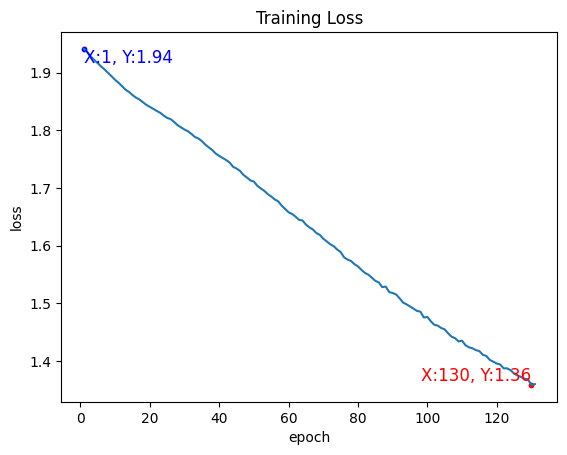

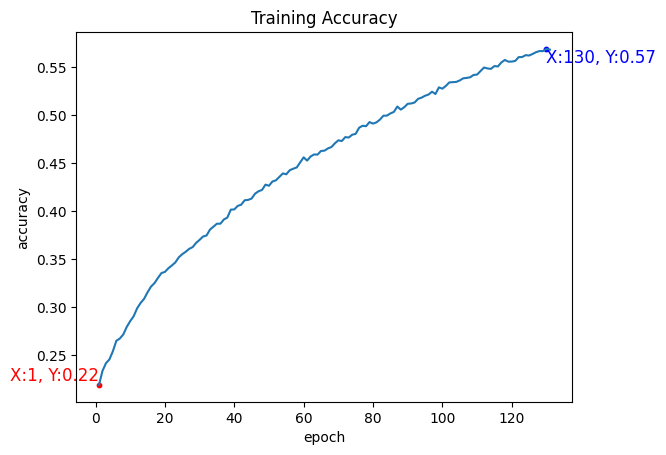

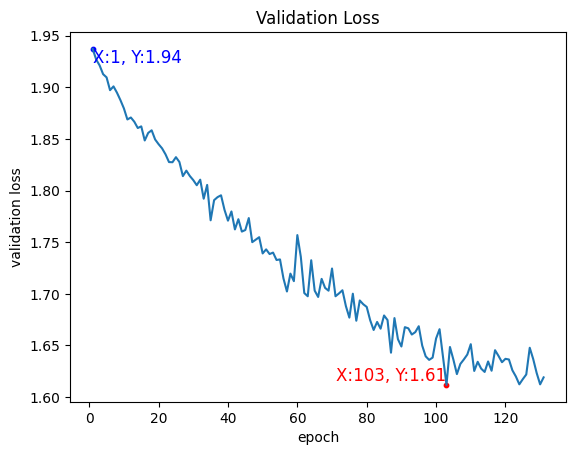

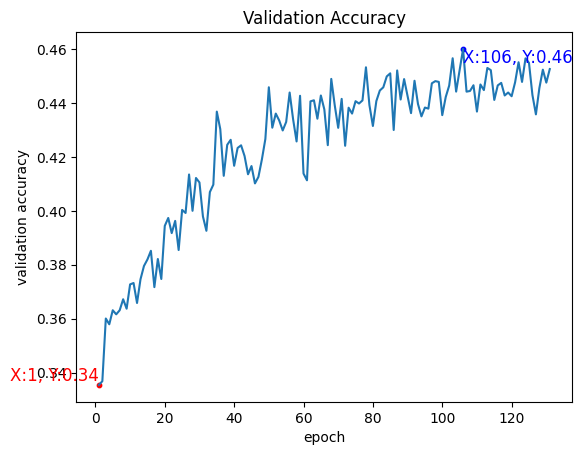

In [18]:
# draw graphs
data = utility.read_pickle_files(m.record_save_path + '/loss_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="loss", title="Training Loss", 
                    save_path=m.record_save_path+"/loss_history.png")

data = utility.read_pickle_files(m.record_save_path + '/accuracy_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="accuracy", title="Training Accuracy",
                    save_path=m.record_save_path+"/accuracy_history.png")

data = utility.read_pickle_files(m.record_save_path + '/val_loss_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation loss",
                    title="Validation Loss", save_path=m.record_save_path+"/val_loss_history.png")

data = utility.read_pickle_files(
    m.record_save_path + '/val_accuracy_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation accuracy",
                    title="Validation Accuracy", save_path=m.record_save_path+"/val_accuracy_history.png")


model weight path: ./model_data/Alex_4096_relu_Adam_d1d2_wb_tl/model.pth
Test Accuracy: 48.996935079409305%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.51      0.19      0.28      1024
           3       0.87      0.60      0.71      1774
           4       0.35      0.81      0.48      1233
           5       0.44      0.41      0.42      1247
           6       0.49      0.89      0.63       831

    accuracy                           0.49      7178
   macro avg       0.38      0.42      0.36      7178
weighted avg       0.48      0.49      0.45      7178



/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 47.315049550587695%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1041
           1       0.00      0.00      0.00       655
           2       0.35      0.22      0.27       691
           3       0.86      0.24      0.37      5459
           4       0.46      0.86      0.60      5858
           5       0.35      0.34      0.34      2177
           6       0.42      0.66      0.51      1475

    accuracy                           0.47     17356
   macro avg       0.35      0.33      0.30     17356
weighted avg       0.52      0.47      0.42     17356

model weight path: ./model_data/Alex_4096_relu_Adam_d1d2_wb_tl/manual_save_model.pth


/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 48.95514070771803%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.54      0.23      0.32      1024
           3       0.90      0.56      0.69      1774
           4       0.35      0.80      0.49      1233
           5       0.42      0.45      0.43      1247
           6       0.50      0.88      0.64       831

    accuracy                           0.49      7178
   macro avg       0.39      0.42      0.37      7178
weighted avg       0.49      0.49      0.45      7178



/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 46.46231850656833%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1041
           1       0.00      0.00      0.00       655
           2       0.33      0.26      0.29       691
           3       0.88      0.22      0.36      5459
           4       0.46      0.85      0.60      5858
           5       0.31      0.37      0.34      2177
           6       0.42      0.62      0.50      1475

    accuracy                           0.46     17356
   macro avg       0.34      0.33      0.30     17356
weighted avg       0.52      0.46      0.41     17356

model weight path: ./model_data/Alex_4096_relu_Adam_d1d2_wb_tl/best_loss_model.pth


/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 48.96907216494845%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.60      0.11      0.19      1024
           3       0.85      0.61      0.71      1774
           4       0.34      0.87      0.48      1233
           5       0.42      0.43      0.43      1247
           6       0.57      0.86      0.68       831

    accuracy                           0.49      7178
   macro avg       0.40      0.41      0.36      7178
weighted avg       0.49      0.49      0.44      7178



/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 47.87393408619498%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1041
           1       0.00      0.00      0.00       655
           2       0.42      0.12      0.19       691
           3       0.86      0.24      0.38      5459
           4       0.45      0.90      0.60      5858
           5       0.33      0.36      0.35      2177
           6       0.52      0.56      0.54      1475

    accuracy                           0.48     17356
   macro avg       0.37      0.31      0.29     17356
weighted avg       0.53      0.48      0.42     17356



/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hhf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 700x700 with 0 Axes>

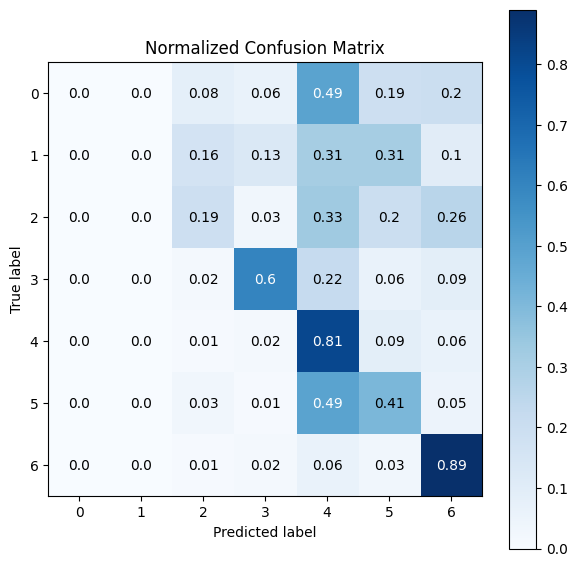

<Figure size 700x700 with 0 Axes>

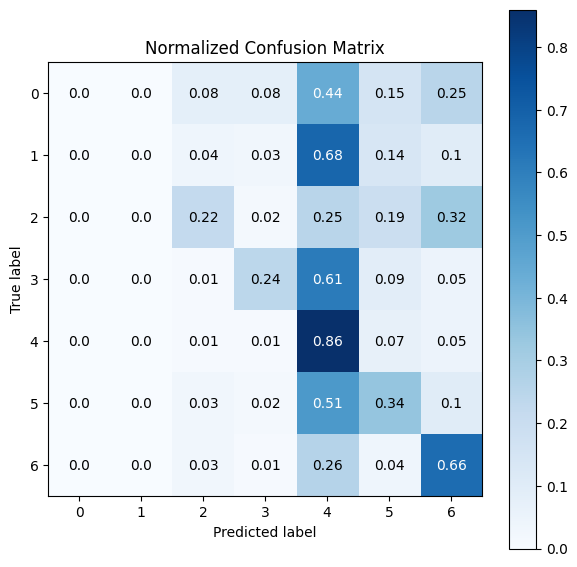

<Figure size 700x700 with 0 Axes>

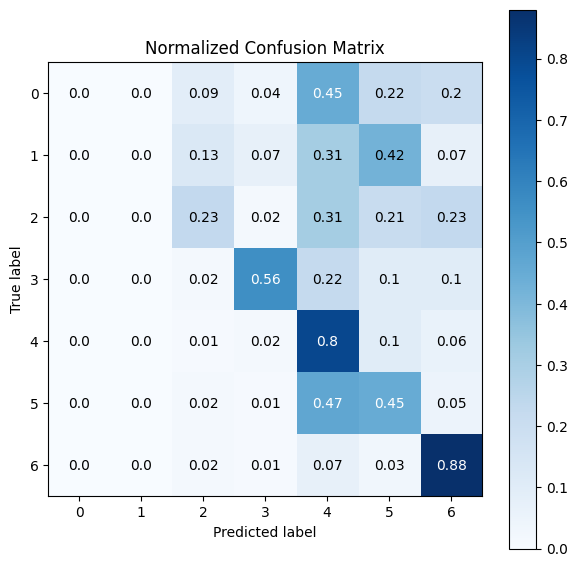

<Figure size 700x700 with 0 Axes>

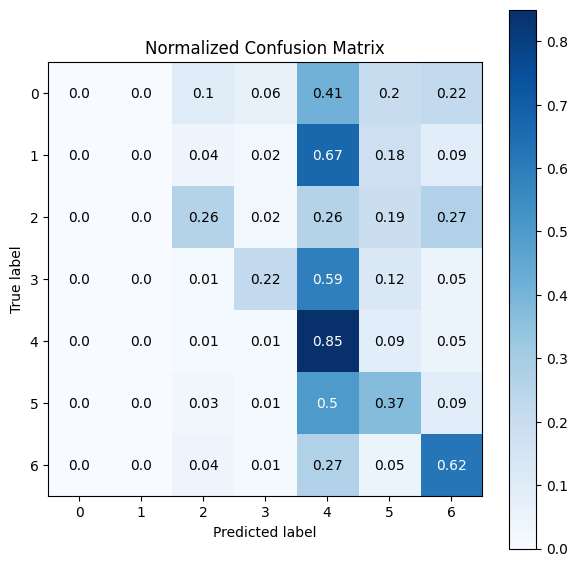

<Figure size 700x700 with 0 Axes>

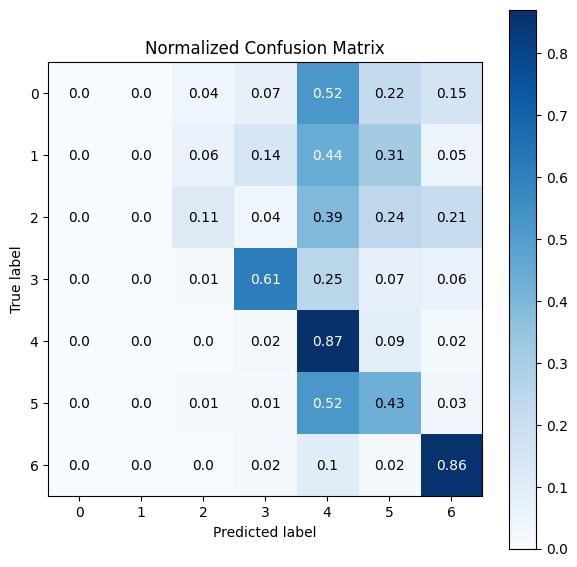

<Figure size 700x700 with 0 Axes>

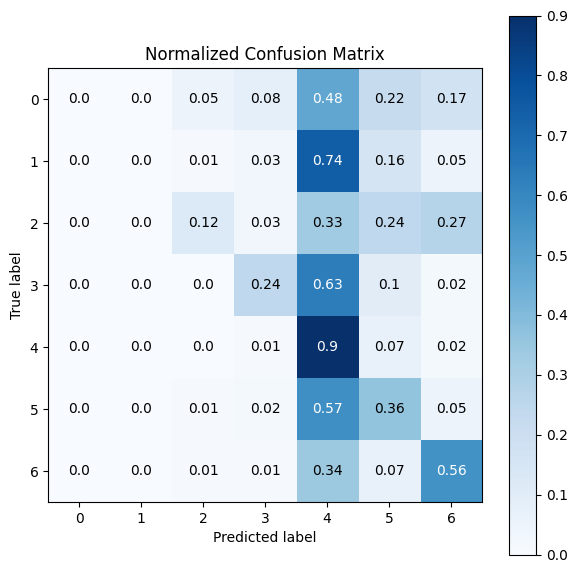

In [19]:
# evaluate model
print(f'model weight path: {m.pth_save_path}')
utility.model_validation(model, device, test_loader, m.pth_save_path, m.record_save_path, file_name='1-0')
utility.model_validation(model, device, test_loader2, m.pth_save_path, m.record_save_path, file_name='1-1')
print(f'model weight path: {m.pth_manual_save_path}')
utility.model_validation(model, device, test_loader, m.pth_manual_save_path, m.record_save_path, file_name='2-0')
utility.model_validation(model, device, test_loader2, m.pth_manual_save_path, m.record_save_path, file_name='2-1')
print(f'model weight path: {m.pth_save_path_loss}')
utility.model_validation(model, device, test_loader, m.pth_save_path_loss, m.record_save_path, file_name='3-0')
utility.model_validation(model, device, test_loader2, m.pth_save_path_loss, m.record_save_path, file_name='3-1')